In [12]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

In [18]:
# Create proteostasis table
with open("/Users/pomato/mrc/project/sita_slam-seq/data/PROJ1624_genelist_2.txt") as file:
    gene_list = set([line.rstrip('\n') for line in file])

gene_df = pd.DataFrame(gene_list, columns=['symbol'])

print(f"No. of genes: {len(gene_list)} \n")


No. of genes: 25 



In [20]:
cols = ['DMSO_TDP43_vs_DMSO_NoAgg', 'C13_TDP43_vs_DMSO_TDP43']
# 'DMSO_TDP43_vs_DMSO_NoAgg' 'C13_NoAgg_vs_DMSO_NoAgg'

for col in cols:
    gene_df[col] = np.nan

fc_df = gene_df
#padj_df = gene_df

for col in cols:
    # Load DESeq2 output table
    deseq_files = glob.glob(f"/Users/pomato/mrc/project/sita_slam-seq/data/deseq_outputs/*{col}*.txt")

    if len(deseq_files) > 0:
        deseq_df = pd.read_csv(deseq_files[0], sep="\t")

        print(f"{col}: Filtering for selected genes...")
        deseq_df_filt = deseq_df[deseq_df['geneSymbol'].isin(gene_df['symbol'])]
        print(f"{len(deseq_df_filt)} out of {len(deseq_df)} genes ({len(deseq_df_filt) / len(deseq_df) * 100}%) kept.")

        print(f"Filling gene table with fold-change and padj values...\n")
        for i in deseq_df_filt['geneSymbol'].values:
            fc_df.loc[fc_df['symbol'] == i, col] = deseq_df_filt.loc[deseq_df_filt['geneSymbol'] == i, 'log2FoldChange'][0]
            #padj_df.loc[padj_df['symbol'] == i, col] = deseq_df_filt.loc[deseq_df_filt['geneSymbol'] == i, 'padj'][0]  
    else:
        print(f"{col}: DESeq2 output table not found. Skipping...\n")


fc_df.to_csv(f"~/mrc/project/sita_slam-seq/data/PROJ1624_foldChange.txt", sep="\t", header=True, index=False)
#padj_df.to_csv(f"~/mrc/project/sita_slam-seq/data/PROJ1624_padj.txt", sep="\t", header=True, index=False)

DMSO_TDP43_vs_DMSO_NoAgg: Filtering for selected genes...
25 out of 11805 genes (0.21177467174925876%) kept.
Filling gene table with fold-change and padj values...

C13_TDP43_vs_DMSO_TDP43: Filtering for selected genes...
25 out of 11805 genes (0.21177467174925876%) kept.
Filling gene table with fold-change and padj values...



In [32]:
#### Fold-changes of custom genes
genes = ['Hdac9']
fc_custom = pd.DataFrame(index=genes, columns=gses)
padj_custom = pd.DataFrame(index=genes, columns=gses)

drop_gses = []

for gse in gses:
    # Load DESeq2 output table
    deseq_files = glob.glob(f"/Users/pomato/mrc/project/rna-seq/data/deseq_outputs/{gse}*.txt")
    if len(deseq_files) > 0:
        deseq_df = pd.read_csv(deseq_files[0], sep="\t")

        for gene in genes:
            fc_custom.loc[gene, gse] = deseq_df.loc[deseq_df['geneSymbol'] == gene, 'log2FoldChange'][0]
            padj_custom.loc[gene, gse] = deseq_df.loc[deseq_df['geneSymbol'] == gene, 'padj'][0]
    else:
        print(f"{gse} DESeq2 output file not found.")
        drop_gses.append(gse)

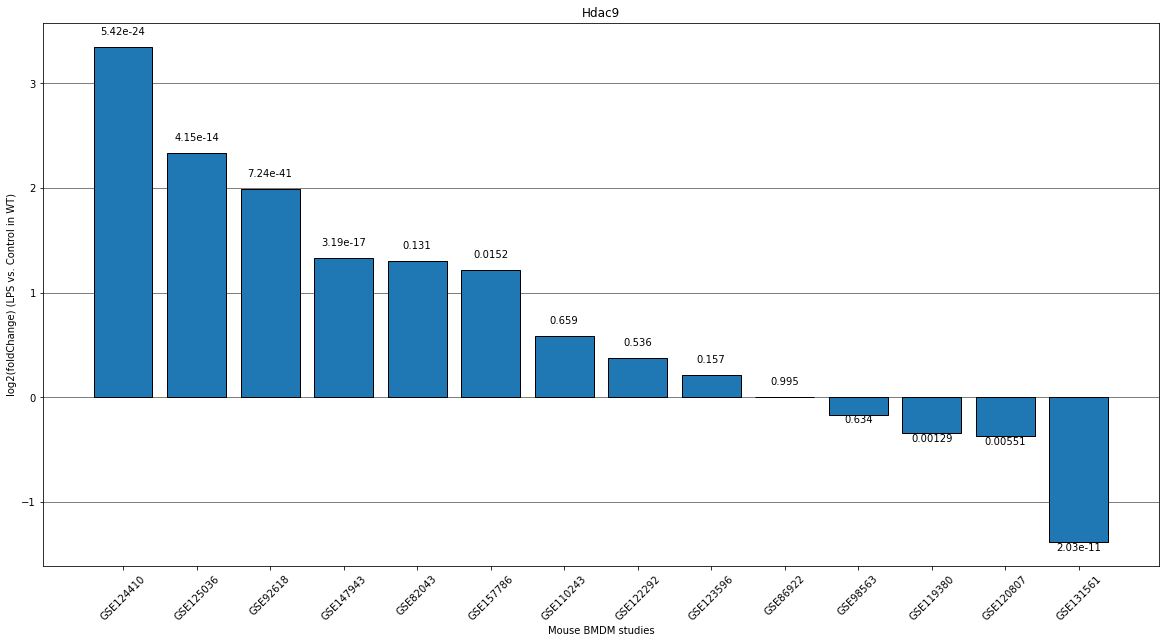

In [24]:
# Bar plot
gene = 'Hdac9'

fc_custom_drop = fc_custom.drop(drop_gses, axis=1)
padj_custom_drop = padj_custom.drop(drop_gses, axis=1)

fc_gene = fc_custom_drop.loc[gene].sort_values(ascending=False)
padj_gene = padj_custom_drop.loc[gene].reindex(fc_gene.index)

gses = fc_gene.index.tolist()
fcs = fc_gene.values.tolist()
padjs = padj_gene.values.tolist()

fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(gses, fcs, edgecolor='black')

# Add padj as labels
rects = ax.patches
labels = ['%.3g' % padj for padj in padj_gene.tolist()]

for rect, label in zip(rects, labels):
    height = rect.get_height()

    shift = 0.1 if height > 0 else -0.1
    
    ax.text(rect.get_x() + rect.get_width() / 2, height + shift, label,
            ha='center', va='bottom')

plt.xticks(rotation=45)
plt.xlabel("Mouse BMDM studies")
plt.ylabel("log2(foldChange) (LPS vs. Control in WT)")
plt.title(gene)

ax.yaxis.grid(linewidth=0.5,color='black')
ax.set_axisbelow(True)

In [38]:
drop_gses

[]